# Picture graph structure of code snippet

This task is carried out using two different libraries: `python_graphs` and `ast`. 

In both cases, graph generation was run on sample code located in the folder `code snippets`.

The results for the first library can be found in the folder `result_python_graphs` and for the second in the folder `result_ast`.

In [11]:
import os
import ast
import networkx
from python_graphs import control_flow, control_flow_graphviz
from IPython.display import Image

In [12]:
def make_pictures(source_dir, output_dir, function_to_vizualize):
    for file in os.listdir(source_dir):
        filename = file.split('.')[0]
        with open(f'{source_dir}/{file}', "r") as f:
            source = f.read()
        function_to_vizualize(source, f"{output_dir}/{filename}.png")

## python_graphs

In [13]:
def vizualize_by_python_graphs(code_snippet, output_directory):
    graph = control_flow.get_control_flow_graph(code_snippet)
    control_flow_graphviz.render(graph, include_src=code_snippet, path=output_directory)

In [14]:
make_pictures("snippets", "result_python_graphs", vizualize_by_python_graphs)

### Example of the resulting image

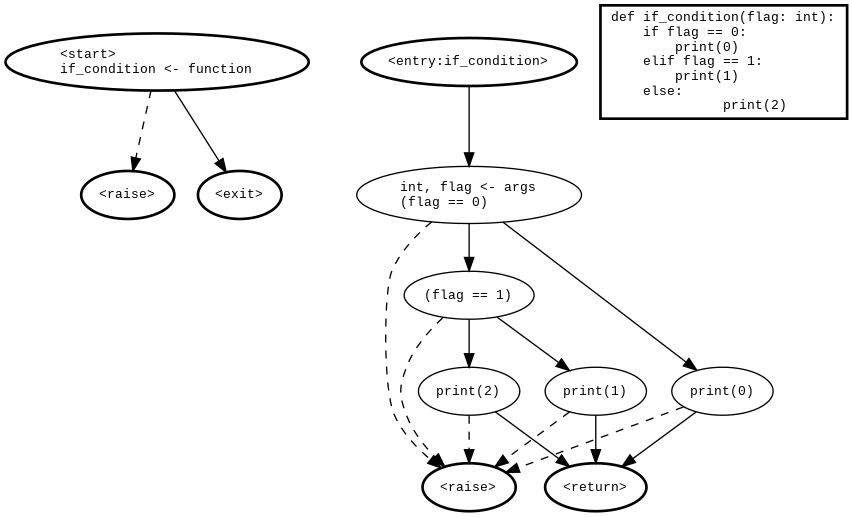

In [15]:
Image(filename='result_python_graphs/if_condition.png')

### Types of nodes and edges

#### Edges:
- **dashed** for transitions that have not been described by the code and may occur in the middle of a programme (example: a thrown exception)
- **solid** for transition to the next statementin code

For boolean conditions right edge is for `true` and left is for `false`.

#### Nodes:
 - **thick border** for start(example: function name) and end (example: return) statements
 
 - **thin border** for all other statements (arguments, conditions, calls)


## ast

In [16]:
def get_label(node):
    if isinstance(node, ast.FunctionDef):
        return f"Function {node.name}"
    if isinstance(node, ast.Name):
        return f"Name {node.id}"
    if isinstance(node, ast.arg):
        return f"arg {node.arg}"
    if isinstance(node, ast.Constant):
        return f"Const {node.value}"
    if isinstance(node, ast.Attribute):
        return f"Attr {node.attr}"
    if isinstance(node, ast.ClassDef):
        return f"Class {node.name}"
    return node.__class__.__name__

In [17]:
class ASTVisitor():
    def __init__(self):
        self.graph = networkx.DiGraph()
        self.count = 0
    
    def visit(self, node: ast.AST):
        cur_count = self.count
        label = get_label(node)
        self.graph.add_node(cur_count, label=label, shape='rect')
        self.count += 1

        for field, value in ast.iter_fields(node):
            if isinstance(value, list):
                for item in value:
                    if isinstance(item, ast.AST):
                        child_count = self.visit(item)
                        self.graph.add_edge(cur_count, child_count)
            elif isinstance(value, ast.AST):
                child_count = self.visit(value)
                self.graph.add_edge(cur_count, child_count)
        return cur_count

In [18]:
def vizualize_by_ast(code_snippet, output_directory):
    ast_object = ast.parse(code_snippet)
    visitor = ASTVisitor()
    visitor.visit(ast_object)
    networkx.drawing.nx_pydot.to_pydot(visitor.graph).write_png(output_directory)

In [19]:
make_pictures("snippets", "result_ast", vizualize_by_ast)

### Example of the resulting image

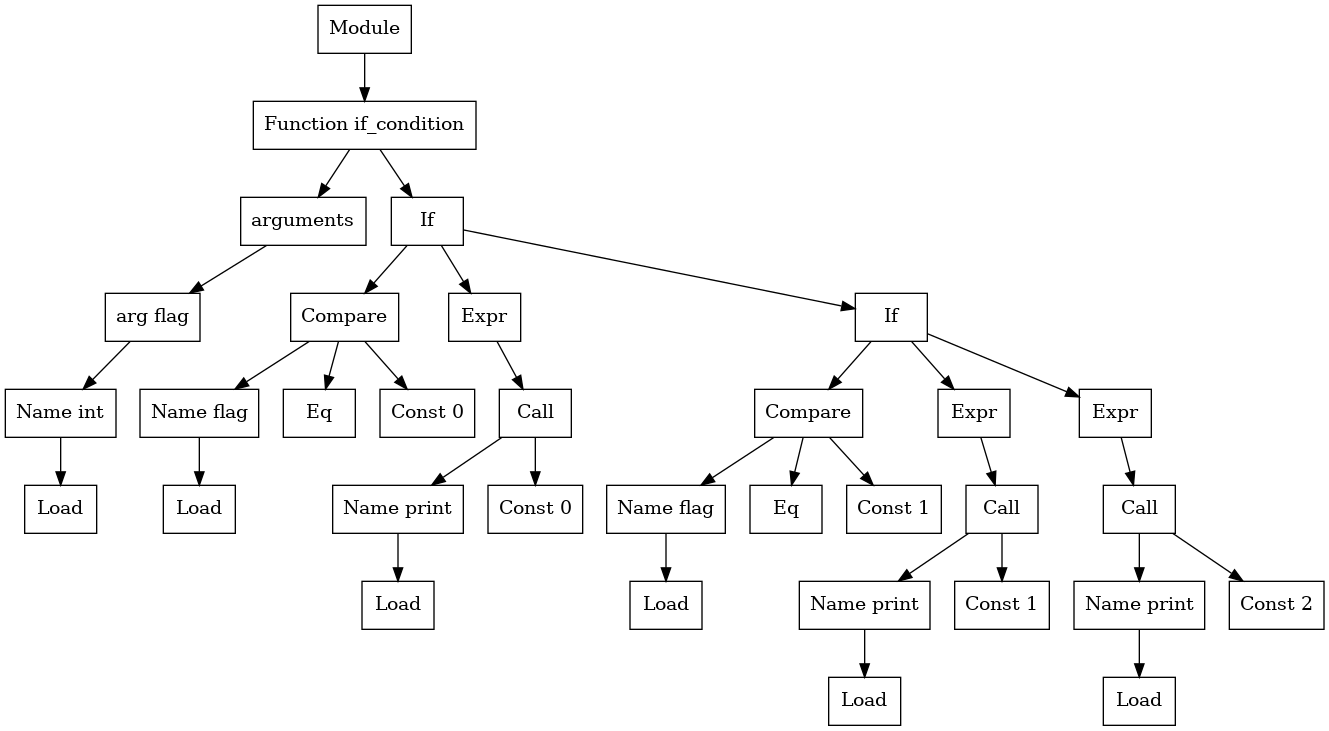

In [20]:
Image(filename='result_ast/if_condition.png')

### Types of nodes and edges

#### Edges:

Сonnects the module to its component

#### Nodes:

Components of the program: arguments, attributes, constants, calls, operations, conditions

## Summary:

`python_graphs` library builds more compact graphs, the expressions in the nodes are easier to read, and it has functions to visualize the resulting graph. However, there may be too many expressions in one node, they are not separated from each other in any way, so many edges may come out of one node, which prevents from understanding the image


`ast` library does not contain built-in functions for graph visualization, but when using `networkx` it is not hard to do. The library is more convenient in case it is necessary to customize a graph, you can set the design of nodes and edges, their labels, colours, etc. Graphs are more extensive, but it is better to divide them into components, each component is allocated to a separate node. 